In [1]:
#import the important libaries
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from agent_navigation import Agent
import time
import random

/home/osboxes/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370193460/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#definition hyperparameters and trainingsconditions
max_episodes = 100
max_timestaps = 1000
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
training_mode = True
gamma = 0.99

#environment parameters
state_size = 37
action_size = 4
seed = 0

In [3]:
#define the environment
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

#get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#get number of possible actions
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 1.97


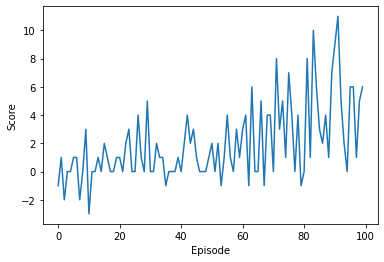

In [4]:
#define an agent
agent = Agent(state_size, action_size, seed)

#counter to print envirement sloved only once
counter = 0

#train the agent
def dqn_train(n_episodes, max_t, eps_start, eps_end, eps_decay):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #list containing scores from each episode
    scores = []
    #last 100 scores
    scores_window = deque(maxlen=100)
    #initialize epsilon
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        global counter
        #reset the environment
        env_info = env.reset(train_mode=training_mode)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            #select an action
            action = agent.act(state)
            #send the action to the environment
            env_info = env.step(action)[brain_name]  
            #get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            #see if episode has finished
            done = env_info.local_done[0]
            #save step in memory and learn from this step
            agent.step(state, action, reward, next_state, done)
            #update the score
            score += reward
            #roll over the state to next time step
            state = next_state
            # exit loop if episode finished
            if done:
                break
        #save most recent score
        scores_window.append(score)
        #save most recent score
        scores.append(score)
        #decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13 and counter == 0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            counter = 1
    return scores
            
torch.save(agent.qnetwork_local.state_dict(), 'checkpointTest.pth')
scores = dqn_train(max_episodes, max_timestaps, max_epsilon, min_epsilon, epsilon_decay)

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [5]:
from model import QNetwork
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(agent.qnetwork_local.state_dict().keys())
print(agent)
for param in agent.qnetwork_local.parameters():
    print(param.data)

state_dict = torch.load('checkpointTest.pth')
print(state_dict.keys())
trained_model = QNetwork(state_size, action_size, seed).to(device)
trained_model.load_state_dict(state_dict)
trained_model.eval()
agent2 = Agent(state_size, action_size, seed)
agent2.qnetwork_local = trained_model
print(agent2)
for param in agent2.qnetwork_local.parameters():
    print(param.data)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
tensor([[-0.1400,  0.1452, -0.0689,  ..., -0.1937, -0.1773, -0.0598],
        [ 0.1625,  0.0402, -0.0494,  ..., -0.2056,  0.0750,  0.0908],
        [ 0.0840,  0.1212,  0.2352,  ..., -0.1376,  0.0963, -0.0673],
        ...,
        [-0.0550, -0.0572,  0.1627,  ..., -0.1642,  0.0070,  0.0037],
        [ 0.0688, -0.0224,  0.0648,  ..., -0.0080,  0.0214,  0.0328],
        [-0.1106, -0.0762, -0.1512,  ..., -0.0753, -0.0544,  0.0095]])
tensor([ 0.1268, -0.0534, -0.1504, -0.0806,  0.1204, -0.0456, -0.1050,  0.0807,
        -0.0142, -0.1612,  0.1317,  0.0968,  0.1249,  0.1105, -0.0505, -0.0849,
         0.0593, -0.0892,  0.0054, -0.1675, -0.1341, -0.0089, -0.0313, -0.0918,
        -0.1757,  0.1110, -0.0472, -0.1997,  0.1309,  0.1188, -0.0820, -0.1523,
         0.1451, -0.0440, -0.1180,  0.0518, -0.0399, -0.0127, -0.0757, -0.1194,
        -0.0543, -0.0489, -0.1607,  0.1496, -0.0079, -0.0537,  0.0265, -0.1

Episode 10	Average Score: 0.00

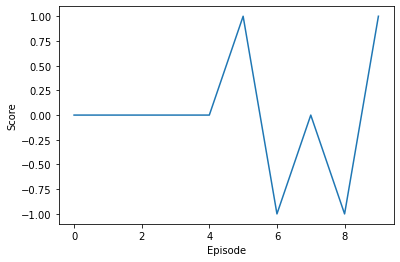

In [6]:
#use agent2
def dqn_train(n_episodes, max_t, eps_start, eps_end, eps_decay):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #list containing scores from each episode
    scores = []
    #last 100 scores
    scores_window = deque(maxlen=100)
    #initialize epsilon
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        global counter
        #reset the environment
        env_info = env.reset(train_mode=training_mode)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            #select an action
            action = agent2.act(state)
            #send the action to the environment
            env_info = env.step(action)[brain_name]  
            #get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            #see if episode has finished
            done = env_info.local_done[0]
            #save step in memory and learn from this step
            #agent2.step(state, action, reward, next_state, done)
            #update the score
            score += reward
            #roll over the state to next time step
            state = next_state
            # exit loop if episode finished
            if done:
                break
        #save most recent score
        scores_window.append(score)
        #save most recent score
        scores.append(score)
        #decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13 and counter == 0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            counter = 1
    return scores
            
scores = dqn_train(10, max_timestaps, max_epsilon, min_epsilon, epsilon_decay)

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [7]:
#close the environment
env.close()